# **Behavioral Cloning** 
---

**Behavioral Cloning Project**

The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report


[//]: # (Image References)

[image1]: ./examples/placeholder.png "Model Visualization"
[image2]: ./examples/placeholder.png "Grayscaling"
[image3]: ./examples/placeholder_small.png "Recovery Image"
[image4]: ./examples/placeholder_small.png "Recovery Image"
[image5]: ./examples/placeholder_small.png "Recovery Image"
[image6]: ./examples/placeholder_small.png "Normal Image"
[image7]: ./examples/placeholder_small.png "Flipped Image"

## Rubric Points
### Here I will consider the [rubric points](https://review.udacity.com/#!/rubrics/432/view) individually and describe how I addressed each point in my implementation.  

---
### Files Submitted & Code Quality

#### 1. Submission includes all required files and can be used to run the simulator in autonomous mode

My project includes the following files:
* model.py containing the script to create and train the model
* drive.py for driving the car in autonomous mode
* model.h5 containing a trained convolution neural network 
* writeup_report.md or writeup_report.pdf summarizing the results

#### 2. Submission includes functional code
Using the Udacity provided simulator and my drive.py file, the car can be driven autonomously around the track by executing 
```sh
python drive.py model.h5
```

#### 3. Submission code is usable and readable

The model.py file contains the code for training and saving the convolution neural network. The file shows the pipeline I used for training and validating the model, and it contains comments to explain how the code works.

### Model Architecture and Training Strategy

#### 1. An appropriate model architecture has been employed

My model consists of a convolution neural network with 3x3 filter sizes and depths between 32 and 128 (model.py lines 18-24) 

The model includes RELU layers to introduce nonlinearity (code line 20), and the data is normalized in the model using a Keras lambda layer (code line 18). 

#### 2. Attempts to reduce overfitting in the model

The model contains dropout layers in order to reduce overfitting (model.py lines 21). 

The model was trained and validated on different data sets to ensure that the model was not overfitting (code line 10-16). The model was tested by running it through the simulator and ensuring that the vehicle could stay on the track.

#### 3. Model parameter tuning

The model used an adam optimizer, so the learning rate was not tuned manually (model.py line 25).

#### 4. Appropriate training data

Training data was chosen to keep the vehicle driving on the road. I used a combination of center lane driving, recovering from the left and right sides of the road ... 

For details about how I created the training data, see the next section. 

### Model Architecture and Training Strategy

#### 1. Solution Design Approach

The overall strategy for deriving a model architecture was to ...

My first step was to use a convolution neural network model similar to the ... I thought this model might be appropriate because ...

In order to gauge how well the model was working, I split my image and steering angle data into a training and validation set. I found that my first model had a low mean squared error on the training set but a high mean squared error on the validation set. This implied that the model was overfitting. 

To combat the overfitting, I modified the model so that ...

Then I ... 

The final step was to run the simulator to see how well the car was driving around track one. There were a few spots where the vehicle fell off the track... to improve the driving behavior in these cases, I ....

At the end of the process, the vehicle is able to drive autonomously around the track without leaving the road.

#### 2. Final Model Architecture

The final model architecture (model.py lines 18-24) consisted of a convolution neural network with the following layers and layer sizes ...

Here is a visualization of the architecture (note: visualizing the architecture is optional according to the project rubric)

![alt text][image1]

#### 3. Creation of the Training Set & Training Process

To capture good driving behavior, I first recorded two laps on track one using center lane driving. Here is an example image of center lane driving:

![alt text][image2]

I then recorded the vehicle recovering from the left side and right sides of the road back to center so that the vehicle would learn to .... These images show what a recovery looks like starting from ... :

![alt text][image3]
![alt text][image4]
![alt text][image5]

Then I repeated this process on track two in order to get more data points.

To augment the data sat, I also flipped images and angles thinking that this would ... For example, here is an image that has then been flipped:

![alt text][image6]
![alt text][image7]

Etc ....

After the collection process, I had X number of data points. I then preprocessed this data by ...


I finally randomly shuffled the data set and put Y% of the data into a validation set. 

I used this training data for training the model. The validation set helped determine if the model was over or under fitting. The ideal number of epochs was Z as evidenced by ... I used an adam optimizer so that manually training the learning rate wasn't necessary.

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from glob import glob
import os

import pickle

%matplotlib inline

In [368]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda,Cropping2D,Input,Flatten,Input,Dropout
from tensorflow.keras.layers import Dense,Convolution2D,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

In [38]:
import tensorflow as tf

## Data Exploration
---

### Loading All Datasets

Here we're going to unify all the data I've collected over several training sessions. This way we can have a single data set to work with going forward.

In [743]:
data_dirs = glob(os.path.join("./train_data/*", ""))
print(data_dirs)

['./train_data/right/', './train_data/center/', './train_data/left/']


### Unifying Data Into a Realtime Generator that Reads from Disk

In [744]:
def unify_data_set_samples(data_dirs):
    path = 'IMG'
    burninframes = 0
    x_rows = np.array([['s1','s2','s3',0.0]])#placeholder initialization

    for dir in data_dirs:
        csv_file = os.path.join(dir,'driving_log.csv')
        cntr = 0
        new_rows = np.array([['s1','s2','s3',0.0]])
        with open(csv_file, 'r') as f:
            rows = pd.read_csv(csv_file,
                               header=None,
                               skiprows=1)
            rows.columns = ['center','left','right','steering','t','b','c']
    
            rows = rows[['center','left','right','steering']].values
            ridx = np.random.choice(range(len(rows)),len(rows),replace=False)
            rows = rows[ridx]
            for row in rows:
                if cntr > burninframes:
                    img_c_path = os.path.join(dir,path,(row[0].split('/')[-1]).strip())
                    img_l_path = os.path.join(dir,path,(row[1].split('/')[-1]).strip())
                    img_r_path = os.path.join(dir,path,(row[2].split('/')[-1]).strip())
                    steering_center = float(row[3])
                    
                    new_row = np.array([[img_c_path,img_l_path,img_r_path,steering_center]])
                    new_rows = np.concatenate((new_rows,new_row))
                
                cntr += 1
            new_rows = new_rows[1::]
        # combining the newfile with the others
        x_rows = np.concatenate((x_rows,new_rows))
    
    return x_rows[1::]

In [745]:
sample_paths = unify_data_set_samples(data_dirs)

In [746]:
sample_paths.shape

(10972, 4)

In [844]:
def uniform_file_paths(samples_path):
    nsamples = len(samples_path)
    
    # finding the corrective steering angles
    high_angle = 0.4
    angle_cuts = high_angle/5*np.array([5,4,3,1])
    angle_cuts = angle_cuts[::-1]
    
    # shuffling the samples_path
    ridx = np.random.choice(range(nsamples),nsamples,replace=False)
    batch_samples = samples_path[ridx]
    
    # initialize 
    images = []
    angles = []
    
    for batch_sample in batch_samples:
        c_img = batch_sample[0]
        l_img = batch_sample[1]
        r_img = batch_sample[2]
        c_steering = float(batch_sample[3])
        directory = (batch_sample[0].split('/'))[-3]
       
        # apply aggressive steering to center correction
        if (directory == 'left'):
            # inside edge driving, correct steer right
            l_steering = c_steering+angle_cuts[3]#np.random.uniform(angle_cuts[2],high=angle_cuts[3])
            r_steering = c_steering+angle_cuts[1]#np.random.uniform(angle_cuts[0],high=angle_cuts[1])
            c_steering = c_steering+angle_cuts[2]#np.random.uniform(angle_cuts[1],high=angle_cuts[2])
        elif (directory == 'right'):
            # outside edge driving, correct steer left
            l_steering = c_steering-angle_cuts[1]#np.random.uniform(angle_cuts[0],high=angle_cuts[1])
            r_steering = c_steering-angle_cuts[3]#np.random.uniform(angle_cuts[2],high=angle_cuts[3])
            c_steering = c_steering-angle_cuts[2]#np.random.uniform(angle_cuts[1],high=angle_cuts[2])
        else:
            l_steering = c_steering+angle_cuts[1]#np.random.uniform(angle_cuts[0],high=angle_cuts[1]) #correct steer right
            r_steering = c_steering-angle_cuts[1]#np.random.uniform(angle_cuts[0],high=angle_cuts[1]) #correct steer left
                
        new_samples = np.array([c_img,l_img,r_img])
        new_angles = np.array([c_steering,l_steering,r_steering])
        
        images.append(new_samples)
        angles.append(new_angles)
        
    images = np.array(images)
    angles = np.array(angles)
    
    images = images.flatten()
    angles = angles.flatten()
    
    images,angles = shuffle(images,angles)
    
    return images,angles

In [845]:
X,y = uniform_file_paths(sample_paths)

In [847]:
X.shape

(32916,)

In [872]:
y_targs = np.concatenate((y,-y))

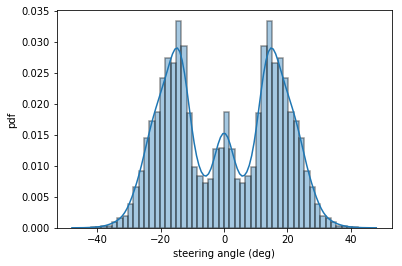

In [879]:
sns.distplot((y_targs*180/np.pi),norm_hist=True,hist_kws=dict(edgecolor="k", linewidth=1.5));
plt.xlabel("steering angle (deg)");
plt.ylabel("pdf");

In [881]:
base_mse = np.mean(y_targs**2)
print('Base MSE score from mean steering angle: ', np.round(base_mse,2))

Base MSE score from mean steering angle:  0.09


In [850]:
with open('./imgs_steer_paths.pkl','wb') as f:
    pickle.dump(sample_paths,f)

In [ ]:
with open('./imgs_steer_paths.pkl','rb') as f:
    sample_paths = pickle.load(f)

In [851]:
# spliting into a train,validation set, split arrays 
# or matrices into random train and test subsets
train_img_paths,valid_img_paths,train_angles,valid_angles = train_test_split(X,y,test_size=0.2,random_state=1337)

In [852]:
def augment(X,y):
    X_flips = np.array([np.fliplr(xi) for xi in X])
    y_flips = np.array([-yi for yi in y])
    
    X_aug = np.concatenate((X,X_flips))
    y_aug = np.concatenate((y,y_flips))
    
    X_aug,y_aug = shuffle(X_aug,y_aug)
    
    return X_aug,y_aug

## Creating a Runtime Data Generator

In [853]:
def data_generator_file(paths,targs,batch_rows=32):
    num_rows = len(paths)
    samples,targs = shuffle(paths,targs)
    
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_rows, batch_rows):
            batch_samples = samples[offset:offset+batch_rows]
            batch_targs = targs[offset:offset+batch_rows]
            
            images = []
            angles = []
            for sample,steer in zip(batch_samples,batch_targs):
                img = plt.imread(sample)
                images.append(img)
                angles.append(steer)
            
            images = np.array(images)
            angles = np.array(angles)
            # apply the augmentation steps
            X_train_batch,y_train_batch = augment(images,angles)
            
            yield X_train_batch, y_train_batch

In [858]:
#generate an example
for xx,yy in data_generator_file(train_img_paths,train_angles,20):
    break

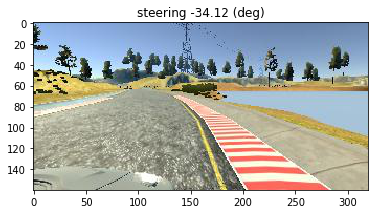

In [864]:
ridx = np.random.choice(range(len(xx)),1)[0]
plt.imshow(np.uint8(xx[ridx]));
plt.title('steering '+str(np.round(yy[ridx]*180/3.14159,2))+' (deg)');

In [865]:
# Set our batch size
batch_size = 128

# compile and train the model using the generator function
train_generator_obj = data_generator_file(train_img_paths,train_angles,batch_size)
validation_generator_obj = data_generator_file(valid_img_paths,valid_angles,batch_size)

In [95]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [870]:
def resnet_model():
    img_rows,img_cols = 160,320
    input_size = 197
    #resnet50 default input is 224x224x3 and can support all the way down to 197x197x3
    rn50_model = ResNet50(weights='imagenet',include_top=False, input_shape=(input_size,input_size,3))
    
    for layer in rn50_model.layers:
        layer.trainable = False
    
    input_img = Input(shape=(img_rows,img_cols,3))
    normalized = Lambda(lambda x: (x-127.5)/127.5,input_shape=(img_rows,img_cols,3))(input_img)
    cropped = Cropping2D(cropping=((65,30),(0,0)))(normalized)
    resized = Lambda(lambda x: tf.image.resize(x,(input_size,input_size)))(cropped)
    
    res_output = rn50_model(resized)
    
    fc1 = Dense(100,activation='relu')(res_output)
    fc2 = Dense(50,activation='relu')(fc1)
    fc3 = Dense(10,activation='relu')(fc2)
    angle = Dense(1,activation='linear')(fc3)
    
    my_model = Model(inputs=input_img,output=angle)
    
    return my_model

In [371]:
from tensorflow.keras.layers import Activation

In [430]:
def generate_nvidia_model():
    in_rows,in_cols = 160,320
    # define the CNN you want to use with preprocessing layers
    model = Sequential()
    #preprocessing
    model.add(Lambda(lambda x: (x-127.5)/127.5,input_shape=(in_rows,in_cols,3)))
    model.add(Cropping2D(cropping=((65,30),(0,0))))
    
    #NETWORK
    #conv_layer1
    model.add(Convolution2D(filters=24,kernel_size=5,strides=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    #conv_layer2
    model.add(Convolution2D(filters=36,kernel_size=5,strides=(2,2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    #conv_layer3
    model.add(Convolution2D(filters=48,kernel_size=5,strides=(2,2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    #conv_layer4
    model.add(Convolution2D(filters=64,kernel_size=3,strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    #conv_layer5
    model.add(Convolution2D(filters=64,kernel_size=3,strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    #FC layers
    # stack outputs in a flattened vector
    model.add(Flatten())

    model.add(Dense(100))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(50))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(10))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    #steering angle
    model.add(Dense(1))
    
    return model

In [431]:
my_model = generate_nvidia_model()

In [432]:
model.compile(loss='mse',optimizer='adam')

In [ ]:
history_object = model.fit_generator(train_generator_obj, 
                                     steps_per_epoch=np.ceil(len(train_sample_paths)/batch_size),
                                     validation_data=validation_generator_obj,
                                     validation_steps=np.ceil(len(valid_sample_paths)/batch_size), 
                                     epochs=1,
                                     workers=-1,
                                     verbose=1)

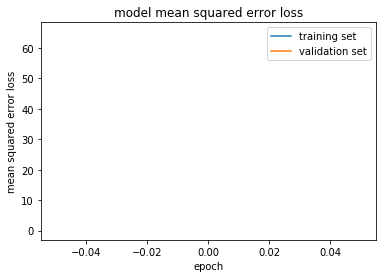

In [294]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()